IMPORT LIBRARIES AND DATASET

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
import pickle

In [80]:
df = pd.read_csv(r"C:\Users\user\Desktop\completeSpamAssassin.csv")

In [81]:
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [83]:
df = df.drop_duplicates(keep='first')

In [84]:
df.duplicated().sum()

0

In [85]:
df.dropna(inplace=True)

In [86]:
df.shape

(6045, 3)

In [87]:
df.drop(['Unnamed: 0'],axis=1, inplace=True)

EDA

In [88]:
df['Label'].value_counts()

Label
0    4150
1    1895
Name: count, dtype: int64

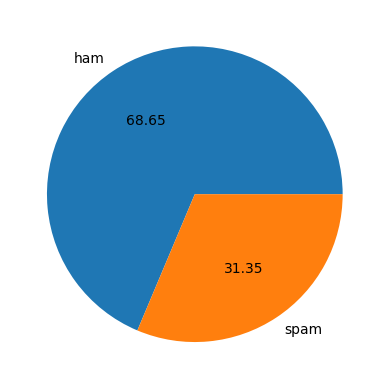

In [89]:
plt.pie(df['Label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [90]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [91]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [92]:
print(df.columns)

Index(['Body', 'Label'], dtype='object')


In [93]:
df['num_char'] = df['Body'].apply(len)

In [94]:
df.head()

,Body,Label,num_char
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610
3,##############################################...,1,2863
4,I thought you might like these:\n1) Slim Down ...,1,641


In [95]:
df['num_words'] = df['Body'].apply(lambda x:len(nltk.word_tokenize(x)))

In [96]:
df['num_sentences'] = df['Body'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [97]:
df.describe()

,Label,num_char,num_words,num_sentences
count,6045.000000,6045.000000,6045.000000,6045.000000
mean,0.313482,1758.272787,328.694458,11.714971
std,0.463947,4940.284032,766.218921,26.649811
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,439.000000,82.000000,3.000000
50%,0.000000,899.000000,172.000000,6.000000
75%,1.000000,1624.000000,317.000000,11.000000
max,1.000000,194978.000000,18564.000000,808.000000


In [98]:
df[df['Label'] == 0][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,4150.000000,4150.00000,4150.000000
mean,1699.373253,322.90000,10.936627
std,4898.320247,757.92311,25.428544
min,5.000000,1.00000,1.000000
25%,450.250000,85.00000,3.000000
50%,896.000000,176.00000,6.000000
75%,1594.750000,318.00000,11.000000
max,194978.000000,18564.00000,808.000000


In [99]:
df[df['Label'] == 1][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,1895.000000,1895.000000,1895.000000
mean,1887.261214,341.384169,13.419525
std,5029.857585,784.133076,29.080556
min,1.000000,0.000000,0.000000
25%,399.000000,70.000000,2.000000
50%,904.000000,162.000000,7.000000
75%,1700.000000,315.500000,12.000000
max,129635.000000,13288.000000,406.000000


<Axes: xlabel='num_char', ylabel='Count'>

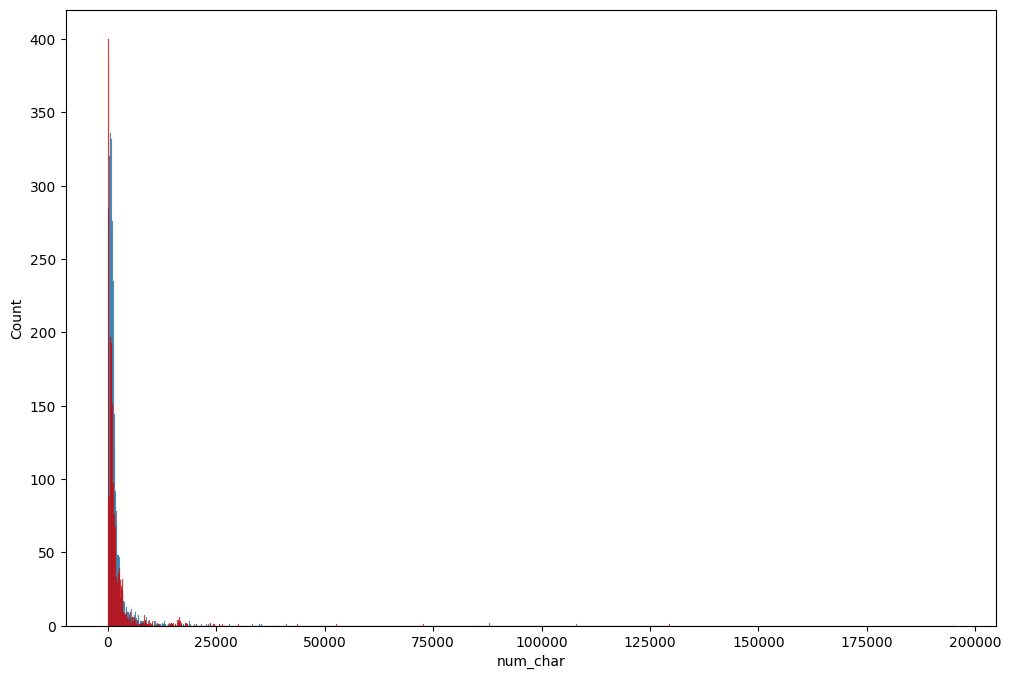

In [100]:
plt.figure(figsize=(12,8))
sns.histplot(df[df['Label'] == 0]['num_char'])
sns.histplot(df[df['Label'] == 1]['num_char'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

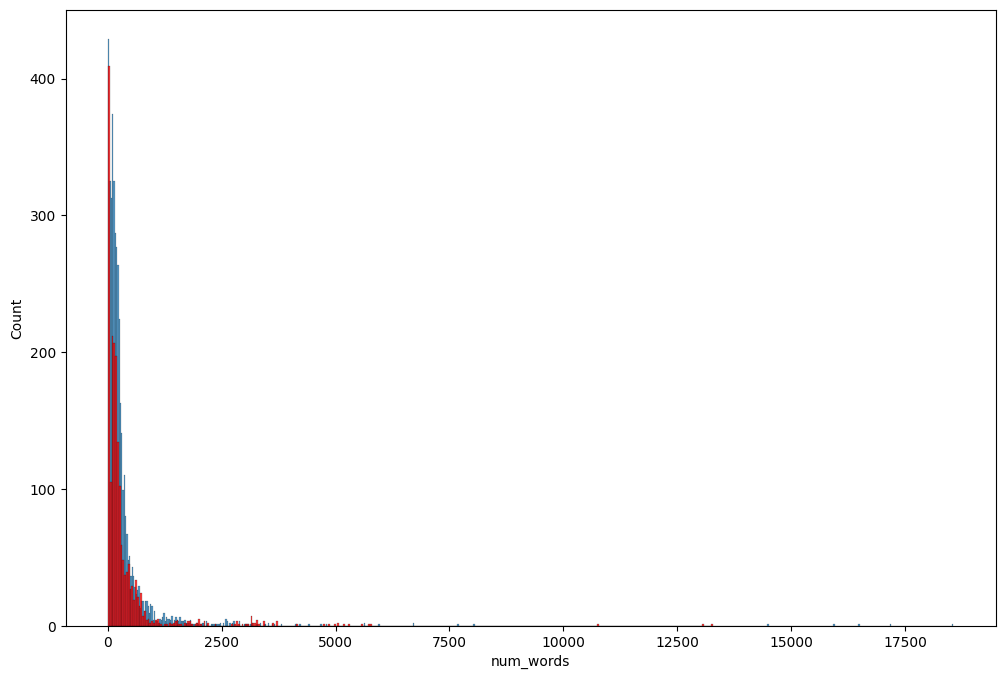

In [101]:
plt.figure(figsize=(12,8))
sns.histplot(df[df['Label'] == 0]['num_words'])
sns.histplot(df[df['Label'] == 1]['num_words'],color='red')

<Axes: xlabel='num_sentences', ylabel='Count'>

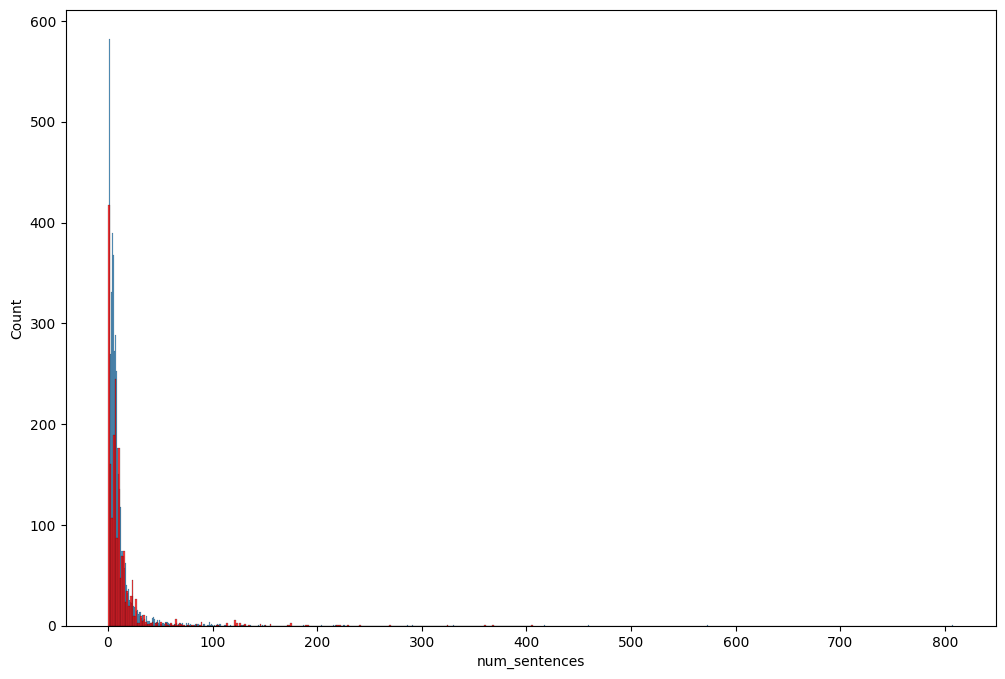

In [102]:
plt.figure(figsize=(12,8))
sns.histplot(df[df['Label'] == 0]['num_sentences'])
sns.histplot(df[df['Label'] == 1]['num_sentences'],color='red')

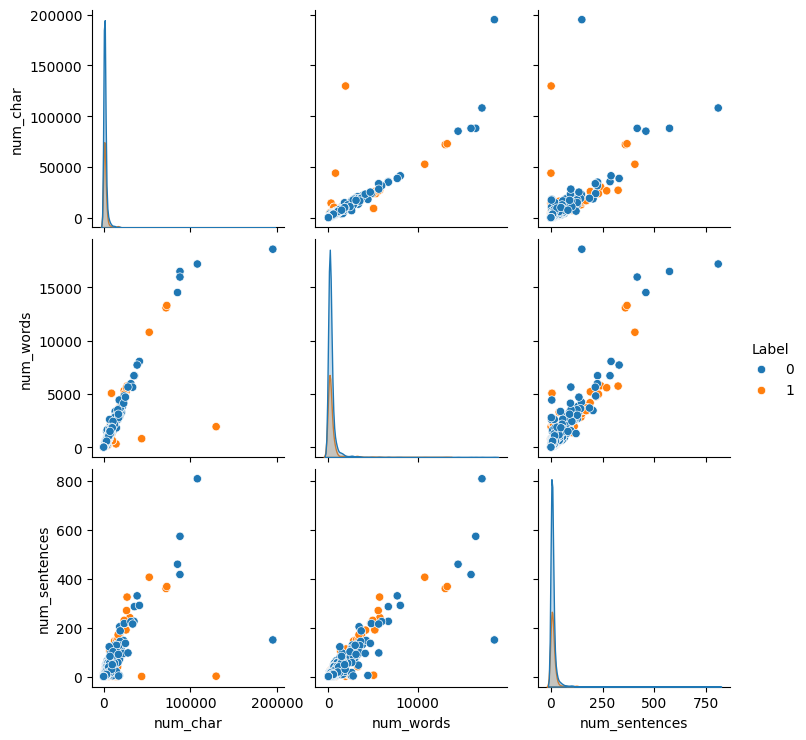

In [103]:
sns.pairplot(df,hue='Label')

In [104]:
ps = PorterStemmer()

In [105]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [106]:
df.head()

,Body,Label,num_char,num_words,num_sentences
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4
3,##############################################...,1,2863,690,35
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4


In [107]:
df['transformed_body'] = df['Body'].apply(transform_text)

In [108]:
df.head()

,Body,Label,num_char,num_words,num_sentences,transformed_body
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12,save 70 life insur spend life quot save ensur ...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5,1 fight risk cancer http slim guarante lose lb...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4,1 fight risk cancer http slim guarante lose lb...
3,##############################################...,1,2863,690,35,adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4,thought might like 1 slim guarante lose lb 30 ...


In [172]:
tfidf = TfidfVectorizer(norm='l2')

In [173]:
X = tfidf.fit_transform(df['transformed_body']).toarray()

In [174]:
Y = df['Label'].values

In [175]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [176]:
gnb = GaussianNB()
gnb.fit(X_train,Y_train)
Y_pred1 = gnb.predict(X_test)
print(accuracy_score(Y_test,Y_pred1))
print(confusion_matrix(Y_test,Y_pred1))
print(precision_score(Y_test,Y_pred1))

0.9065343258891646
[[736  71]
 [ 42 360]]
0.8352668213457076


In [177]:
mnb = MultinomialNB(force_alpha=False)
mnb.fit(X_train,Y_train)
Y_pred2 = mnb.predict(X_test)
print(accuracy_score(Y_test,Y_pred2))
print(confusion_matrix(Y_test,Y_pred2))
print(precision_score(Y_test,Y_pred2))

0.8709677419354839
[[807   0]
 [156 246]]
1.0


In [163]:
bnb = BernoulliNB()
bnb.fit(X_train,Y_train)
Y_pred3 = bnb.predict(X_test)
print(accuracy_score(Y_test,Y_pred3))
print(confusion_matrix(Y_test,Y_pred3))
print(precision_score(Y_test,Y_pred3))

0.9065343258891646
[[803   4]
 [109 293]]
0.9865319865319865


In [164]:
pickle.dump(transform_text ,open('transform.pkl','wb'))
pickle.dump(tfidf,open('tfidf.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))

In [165]:
# Assuming 'mnb' is your Multinomial Naive Bayes model and 'tfidf_vectorizer' is your TfidfVectorizer
new_text = ["""Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.This is an opportunity to make an excellent income.  No experience
is required.  We will train you.So if you are looking to be employed from home with a career that has
vast opportunities, then go:http://www.basetel.com/wealthnowWe are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.To be removed from our link simple go to:http://www.basetel.com/remove.html
4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40
"""]
            # You might need to pass a list or array of texts
transformed_text = [transform_text(text) for text in new_text]
print(transformed_text)
transformed_text = tfidf.transform(transformed_text)
prediction = mnb.predict(transformed_text)

# Now 'prediction' contains the predicted class label for the new text
print(prediction)


['help want 14 year old fortun 500 compani grow tremend rate look individu want work opportun make excel incom experi requir train look employ home career vast opportun go http look energet self motiv peopl click link fill form one employ specialist contact remov link simpl go http']
[1]
